In [15]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/labs/amit/noamsh/repos/sc_clustering')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import scanpy as sc
import anndata as ad
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import config
from pathlib import Path

In [22]:
last_experiment_dir = Path(config.RESULTS_DIR, "simple_clustering_2021_06_16__21_38_32")
final_adata = ad.read(Path(last_experiment_dir, "final_adata.h5ad"))

In [23]:
final_adata.obs["mouse"] = final_adata.obs["arm.day.batch-mouse"].apply(lambda x: x.split(".")[-1])
train_mice , test_mice = train_test_split(final_adata.obs["mouse"].unique(), shuffle=False)
train_mice , test_mice 

(array(['11', '13', '12', '14', '15', '23', '24', '21', '22', '31', '32',
        '33', '34', '35'], dtype=object),
 array(['61', '71', '72', '73', '64'], dtype=object))

In [24]:
final_adata.obs["train"] = final_adata.obs["mouse"].apply(lambda x: x in train_mice)
train_adata = final_adata[final_adata.obs["train"]].copy()
test_adata = final_adata[~ final_adata.obs.train].copy()

... storing 'mouse' as categorical


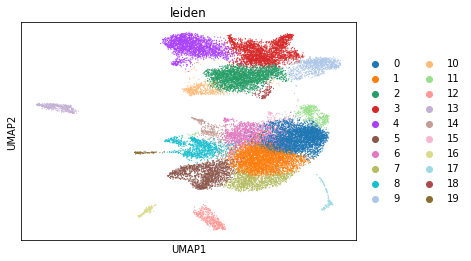

In [26]:
sc.pp.pca(train_adata)
sc.pp.neighbors(train_adata)
sc.tl.umap(train_adata)
sc.tl.leiden(train_adata)

sc.pl.umap(train_adata, color='leiden')

In [7]:
sc.tl.ingest(adata=test_adata, adata_ref=train_adata, obs=clustering_method)

... storing 'mouse' as categorical


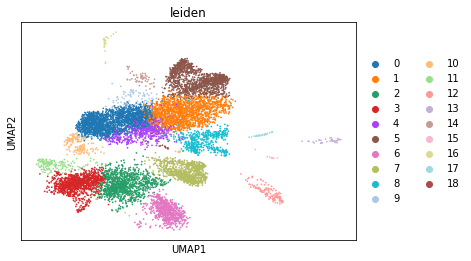

In [25]:
test_adata.uns['leiden_colors'] = train_adata.uns['leiden_colors']  # fix colors
sc.pl.umap(test_adata, color=['leiden'], wspace=0.5)

In [9]:
adata_concat = train_adata.concatenate(test_adata, batch_categories=['train', 'test'])

In [10]:
adata_concat.obs.leiden = adata_concat.obs.leiden.astype('category')
adata_concat.obs.leiden.cat.reorder_categories(train_adata.obs.leiden.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['leiden_colors'] = train_adata.uns['leiden_colors']  # fix category colors

... storing 'arm.day.batch-mouse' as categorical
... storing 'Sorting date' as categorical
... storing 'Gate' as categorical
... storing 'Notes' as categorical
... storing 'Index beginning time' as categorical
... storing 'Index file' as categorical
... storing 'Sorting Notes' as categorical
... storing 'Experimental Batch' as categorical
... storing 'Batch.Set.ID' as categorical
... storing 'Seq.Batch.ID' as categorical
... storing 'Amp.Batch.ID' as categorical
... storing 'Biological replicate' as categorical
... storing 'Libraries date' as categorical
... storing 'Cell % per plate' as categorical
... storing 'mouse' as categorical


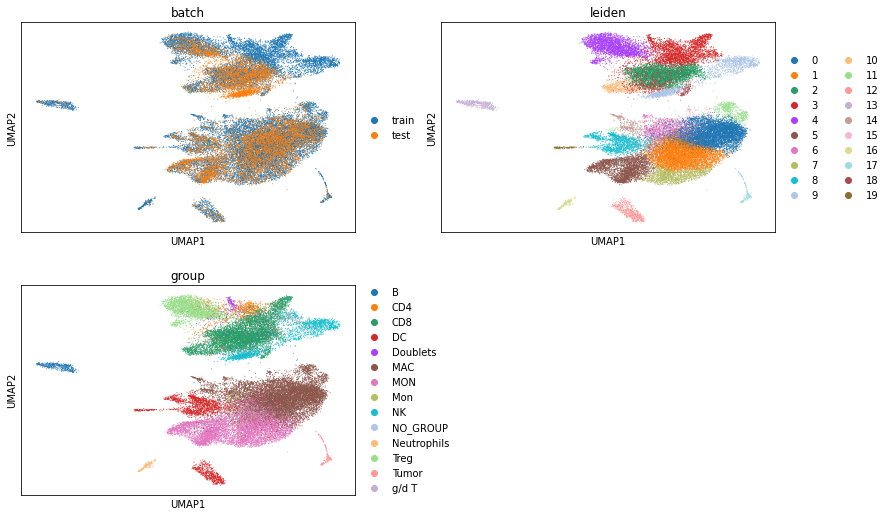

In [11]:
sc.pl.umap(adata_concat, color=['batch', 'leiden', "group"], ncols=2)

... storing 'train' as categorical
... storing 'new_leiden' as categorical


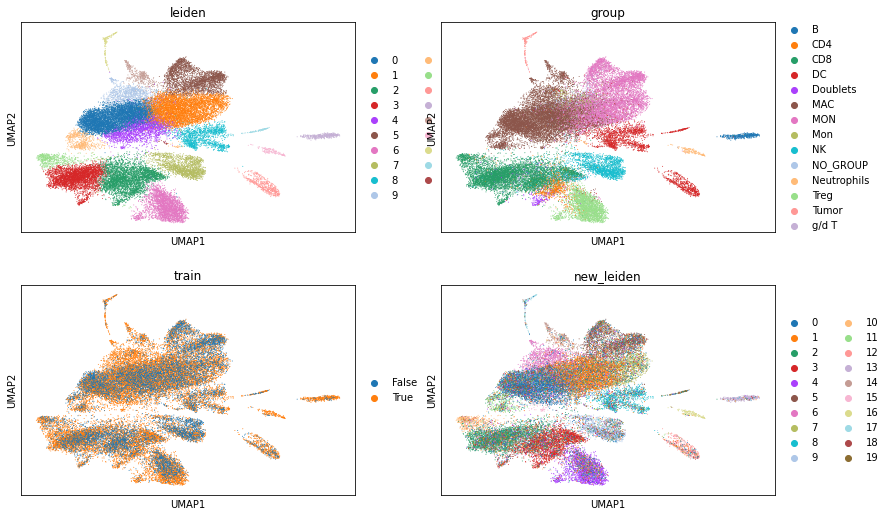

In [30]:
final_adata.obs["train"] = final_adata.obs["train"].astype(str) 
final_adata.obs["new_leiden"] = adata_concat.obs.leiden.to_list()
sc.pl.umap(final_adata, color=["leiden", "group", "train", "new_leiden"], ncols=2)

In [13]:
{
    "AMI": metrics.adjusted_mutual_info_score(final_adata.obs.leiden, adata_concat.obs.leiden),
    "v_score": metrics.v_measure_score(final_adata.obs.leiden, adata_concat.obs.leiden)
}

{'AMI': 0.3981355332257559, 'v_score': 0.39938842256187373}

In [14]:
final_adata.obs.leiden, adata_concat.obs.leiden

(W1072395    9
 W1072396    1
 W1072397    0
 W1072398    2
 W1072399    2
            ..
 W1529428    3
 W1529429    3
 W1529430    3
 W1529431    3
 W1529432    2
 Name: leiden, Length: 33599, dtype: category
 Categories (19, object): ['0', '1', '2', '3', ..., '15', '16', '17', '18'],
 W1072395-train    6
 W1072396-train    1
 W1072397-train    0
 W1072398-train    3
 W1072399-train    3
                  ..
 W1529428-test     2
 W1529429-test     2
 W1529430-test     2
 W1529431-test     2
 W1529432-test     3
 Name: leiden, Length: 33599, dtype: category
 Categories (20, object): ['0', '1', '2', '3', ..., '16', '17', '18', '19'])